In [2]:
# Download train data
import requests
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

In [ ]:
# Data download block

# def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
#     if data_file_path.exists():
#         print(f"{data_file_path} already exists. Skipping download and extraction.")
#         return

#     # Downloading the file
#     response = requests.get(url, stream=True, timeout=60)
#     response.raise_for_status()
#     with open(zip_path, "wb") as out_file:
#         for chunk in response.iter_content(chunk_size=8192):
#             if chunk:
#                 out_file.write(chunk)

#     # Unzipping the file
#     with zipfile.ZipFile(zip_path, "r") as zip_ref:
#         zip_ref.extractall(extracted_path)

#     # Add .tsv file extension
#     original_file_path = Path(extracted_path) / "SMSSpamCollection"
#     os.rename(original_file_path, data_file_path)
#     print(f"File downloaded and saved as {data_file_path}")


# try:
#     download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
# except (requests.exceptions.RequestException, TimeoutError) as e:
#     print(f"Primary URL failed: {e}. Trying backup URL...")
#     url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
#     download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

In [3]:
import pandas as pd
df = pd.read_csv(data_file_path, sep = "\t", header=None, names=["Label", "Text"])
# Show label conunts
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [4]:
# Create smaller dataset wint 747 features
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

# Adding int labels instead of text
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

Label
ham     747
spam    747
Name: count, dtype: int64


In [5]:
# creation of pytotrch dataset
import torch
import torch.nn as nn
import torch.utils.data as data

# Split to test and train
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [6]:
# 6.3 Creating data loaders
from gpt_tools import *
tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})

# Dataset creation

class SpamDataset(data.Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256): # Set len same that a dict size
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        # Adding a truncation option
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length
        # Note: A more pythonic version to implement this method
        # is the following, which is also used in the next chapter:
        # return max(len(encoded_text) for encoded_text in self.encoded_texts)

# Creation of datasets
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

print("Dataset_max_len:", train_dataset.max_length) # the longest sentence in dataset

Dataset_max_len: 120


In [7]:
# Creating data loaders
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

# Checking data loaders
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
130 training batches
19 validation batches
38 test batches


In [11]:
# 6.4 Init model
from gpt_tools import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = GPT_CONFIG_124M

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
BASE_CONFIG.update({"qkv_bias": True})

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

# Creating model with parameters
model = GPTModel(BASE_CONFIG)
# model.to(device)

model.load_state_dict(torch.load("gpt2-small-124M.pth", weights_only=True))
model.eval()

# Testing
token_ids = generate_text_simple(model=model,
                                 idx=text_to_token_ids(INPUT_PROMPT, tokenizer=tokenizer),
                                 max_new_tokens=15,
                                 context_size=BASE_CONFIG["context_length"]
                                 )
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves forward, but it's not enough.

"I'm not going


In [12]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [16]:
# 6.5 Adding a classification head

# disable gradients for all layers
for param in model.parameters():
    param.requires_grad = False

# Replacing the oupput layer
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

# Making last transformer block trainalbe
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True



In [17]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [18]:
print("Last output token:", outputs[:, -1, :])# 6.6

Last output token: tensor([[-3.5983,  3.9902]])


In [19]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


In [20]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [21]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


In [25]:
# 6.7 Calculating the classification loss and accuracy

# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

# Train loop
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 15
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.295, Val loss 0.355
Ep 1 (Step 000050): Train loss 0.354, Val loss 0.522
Ep 1 (Step 000100): Train loss 0.312, Val loss 0.529
Training accuracy: 87.50% | Validation accuracy: 77.50%
Ep 2 (Step 000150): Train loss 0.408, Val loss 0.376
Ep 2 (Step 000200): Train loss 0.479, Val loss 0.415
Ep 2 (Step 000250): Train loss 0.361, Val loss 0.396
Training accuracy: 80.00% | Validation accuracy: 80.00%
Ep 3 (Step 000300): Train loss 0.272, Val loss 0.439
Ep 3 (Step 000350): Train loss 0.345, Val loss 0.329
Training accuracy: 75.00% | Validation accuracy: 72.50%
Ep 4 (Step 000400): Train loss 0.191, Val loss 0.413
Ep 4 (Step 000450): Train loss 0.457, Val loss 0.407
Ep 4 (Step 000500): Train loss 0.414, Val loss 0.511
Training accuracy: 85.00% | Validation accuracy: 82.50%
Ep 5 (Step 000550): Train loss 0.309, Val loss 0.337
Ep 5 (Step 000600): Train loss 0.369, Val loss 0.407
Training accuracy: 97.50% | Validation accuracy: 87.50%
Ep 6 (Step 000650): Train loss 

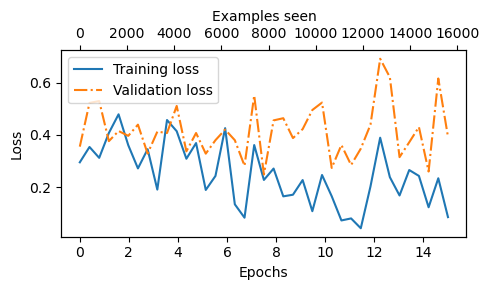

In [26]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [27]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.37%
Validation accuracy: 96.64%
Test accuracy: 95.67%


In [28]:
# 6.8 Using the LLM as a spam classifier
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length must be specified. If you want to use the full model context, "
        "pass max_length=model.pos_emb.weight.shape[0]."
    )
    assert max_length <= supported_context_length, (
        f"max_length ({max_length}) exceeds model's supported context length ({supported_context_length})."
    )    
    # Alternatively, a more robust version is the following one, which handles the max_length=None case better
    # max_len = min(max_length,supported_context_length) if max_length else supported_context_length
    # input_ids = input_ids[:max_len]
    
    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [29]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [30]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [ ]:
# saving model
torch.save(model.state_dict(), "review_classifier.pth")